# Objective
- Demonstrate BART advantage in a complex setting using Friedman 5 dimensional function
- 5 uniform random variables contribute to the hazard through a non-linear and interaction function
- Hazard is proportional throughout w/ weibul alpha set to 2
- Additional 5 uniform RV variables incorporated into the dataset as noise


In [1]:
import sksurv as sks
import sksurv.preprocessing
import sksurv.metrics
import sksurv.datasets
import sksurv.linear_model
import sksurv.ensemble

from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import sklearn as skl
import scipy.stats as sp

import pymc as pm
import pymc_bart as pmb
import pandas as pd

import importlib
import mlflow as ml
import simsurv_func as ssf
import subprocess
import lifelines
import pytensor.tensor as tt
import subprocess

In [2]:
importlib.reload(ssf)

<module 'simsurv_func' from '/home/twj8/pymc_bart/eval_5_cc/simsurv_func.py'>

# Data Generator

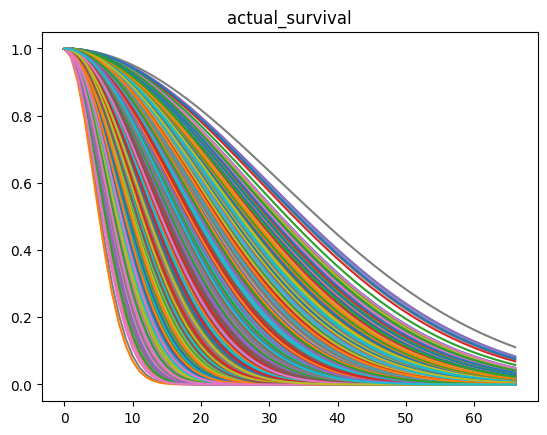

cens_calc: 0.0     
t_mean: 18.612     
t_max: 66.0


In [3]:
OUTPUTS = "outputs"
ALPHA = 2
# ALPHA_F = "3-0.9*x_mat[:,0]"
ALPHA_F = None
VAR_CLASS = [1,1,1,1,1]
VAR_PROB = [0.1, 0.5, 0.5, 0.2]
# friedman 5 dimension function
LAMBDA = "0.001 * np.exp(3+0.5*np.sin(np.pi*x_mat[:,0]*x_mat[:,1]) + np.power(x_mat[:,2],2) + 0.5*x_mat[:,3] + 0.25*x_mat[:,4])" 
# LAMBDA = "0.001 * np.exp(3+0.5*np.sin(np.pi*np.multiply(x_mat[:,0],x_mat[:,1])) + np.power(x_mat[:,2],2) + 0.5*x_mat[:,3] + 0.25*x_mat[:,4])" 
N = 1000
# T = 30
X_VARS = 10
CENS_SCALE = 5# 40
CENS_IND = False
T_CHNG = None

sv_mat, hz_mat, x_mat, lmbda, a, cens, t_event, status, T = ssf.sim_surv2(
                N=N, 
                x_vars=X_VARS,
                VAR_CLASS= VAR_CLASS,
                VAR_PROB = VAR_PROB,
                a = ALPHA,
                alpha_f=ALPHA_F,
                lambda_f = LAMBDA,
                cens_scale=CENS_SCALE,
                cens_ind = CENS_IND,
                err_ind = False,
                T_CHNG=T_CHNG)


# Get information of X vars
x_out, x_idx, x_cnt = ssf.get_x_info(x_mat)
# calculate censored components
event_calc, cens_calc = ssf.get_status_perc(status) 
# Get the t mean and max
t_mean, t_max = ssf.get_event_time_metric(t_event)
# Get the training matrix
train = ssf.get_train_matrix(x_mat, t_event, status)

# plots moved to kpm by group
title = "actual_survival"
ssf.plot_sv(x_mat, sv_mat, T, title=title, save = False, show=True, dir=OUTPUTS)

print(f"cens_calc: {cens_calc} \
    \nt_mean: {t_mean} \
    \nt_max: {t_max}")

# Move average hazard per group below
# get unique x_mat
# x_unique = np.unique(x_mat, return_index=True, axis=0)
# sv_unique = sv_mat[x_unique[1],:]
# hz_unique = np.round(hz_mat[x_unique[1],:],5) 

# HR_unique = hz_unique[1]/hz_unique[0]
# # HR_times = np.arange(0,T,np.floor(T/4), dtype="int")
# HR_times = np.array((np.ceil(T.shape[0]/4) * np.array([1,2,3])), dtype="int")
# print(f"hazard rate 1 {hz_unique[1][HR_times]}")
# print(f"hazard rate 0 {hz_unique[0][HR_times]}")
# print(f"HR t-series = {HR_unique[HR_times]}")
# print(a)

# Transform scale day
- reduce number of computed timepoints

In [4]:
TT_SCALE = 10
tt_sc = t_event.copy()
y_stat = t_event.copy()

tt_sc = np.ceil(tt_sc/TT_SCALE)

## Data Prep

In [5]:
y_sk = ssf.get_y_sklearn(y_stat, tt_sc)
x_sk = train.iloc[:,2:]

# tranform data long-form
b_tr_t, b_tr_delta, b_tr_x = ssf.surv_pre_train2(x_sk, y_sk)

b_te_x = ssf.get_bart_test(x_sk, np.unique(b_tr_t))
off = sp.norm.ppf(np.mean(b_tr_delta))

# BART

- Train bart model
- Split rules are defined as continuous for all variables
- Minimized draws and tune for computational time
    - appears sufficient

In [6]:
# BART
M = 200 # number of trees
DRAWS = 200
TUNE = 200
CORES = 6
SPLIT_RULES = [
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule()
]

with pm.Model() as bart:    
    x_data = pm.MutableData("x", b_tr_x)
    f = pmb.BART("f", X=x_data, Y=b_tr_delta, m=M, split_rules = SPLIT_RULES)
    z = pm.Deterministic("z", f + off)
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    y_pred = pm.Bernoulli("y_pred", p=mu, observed=b_tr_delta, shape=x_data.shape[0])
    bdata = pm.sample(random_seed=2, 
                        draws=DRAWS, 
                        tune =TUNE, 
                        cores=CORES,
                        compute_convergence_checks=False,
                        discard_tuned_samples=True
                        )

with bart:
    pm.set_data({"x":pd.DataFrame(b_te_x)}, coords= {"obs":np.arange(0,b_te_x.shape[0],1)})
    pp = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])



Only 200 samples in chain.
Multiprocess sampling (6 chains in 6 jobs)
PGBART: [f]


Sampling 6 chains for 200 tune and 200 draw iterations (1_200 + 1_200 draws total) took 134 seconds.
Sampling: [f, y_pred]


In [ ]:
# posterior objective
pp

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

- Transform the output to survival values and times using the trained data
- Main vars
    - bart_sv_val 
    - bart_sv_t

In [7]:
# transform to survival
# fill times
t_min = np.unique(b_tr_t).min()
t_fill = np.arange(t_min)
val_fill = np.ones(t_fill.shape)
val_fill = np.repeat(val_fill, x_sk.shape[0]).reshape(x_sk.shape[0],1)

bart_sv_fx = ssf.get_sv_fx(pp, x_sk)
bart_sv_val = np.hstack([val_fill, bart_sv_fx])

bart_sv_t = np.unique(b_tr_t)
bart_sv_t = np.hstack([t_fill, bart_sv_t])

## Posterior Predictive Plot
- posterior predictive check on training samples

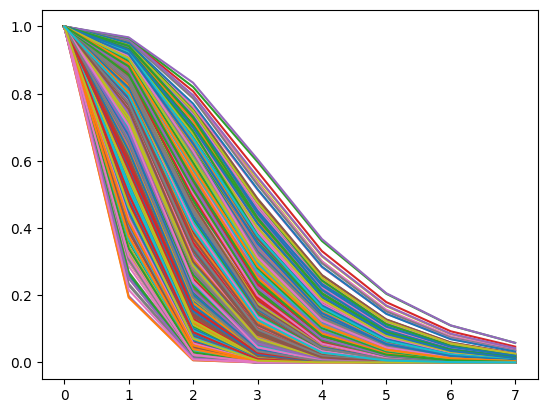

In [8]:
# Plot the posterior predictions
for r in np.arange(0, bart_sv_val.shape[0]):
    plt.plot(bart_sv_t, bart_sv_val[r,:])

- Plot true vs predicted

Text(0, 0.5, 'True')

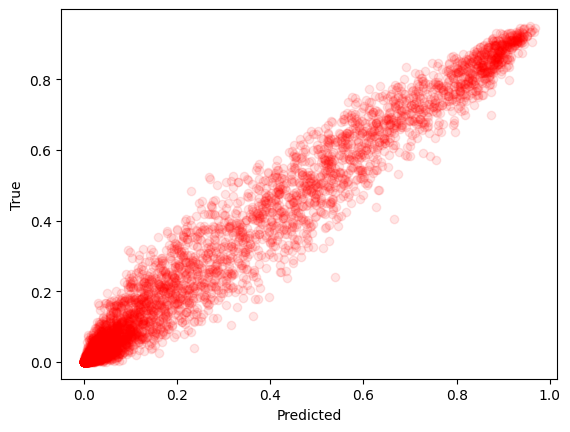

In [9]:
# get sv true
t_msk = np.arange(0,sv_mat.shape[1],TT_SCALE)
sv_true_t = sv_mat[:,t_msk]


for i in np.arange(0,sv_true_t.shape[0]):
    plt.plot(bart_sv_val[i,1:7], sv_true_t[i,1:],"ro", alpha=0.1)

plt.xlabel("Predicted")
plt.ylabel("True")

At 1000 samples the mean predicted values appears to have a 1:1 relationship with the true value

# COX
- Check how the COX model performs
- It should do moderately well since there is no encoded break from proportionality given in the DGP, however the inclusion of the friedman complexity terms should create some difficulty for COX

In [10]:
# check cph
cph = sks.linear_model.CoxPHSurvivalAnalysis().fit(x_sk, y_sk)
print(f"coef: {np.exp(cph.coef_)}")

cph_sv = cph.predict_survival_function(x_sk)
cph_sv = np.array([fx(fx.x) for fx in cph_sv])
cph_sv_val=np.hstack([np.repeat(1,cph_sv.shape[0]).reshape((cph_sv.shape[0],1)), cph_sv])

coef: [1.30210298 1.44167752 4.03656082 1.7909823  1.27586289 0.96920167
 0.98865459 1.07252698 1.00211991 0.90801272]


- The exp coef for the first five variables are correctly elevated, however they are not accurate as HR, as shown by the plots below.
- The last 5 exp coef are not extremely elevated, which is correct. However a few seems to varied by ~ 0.1

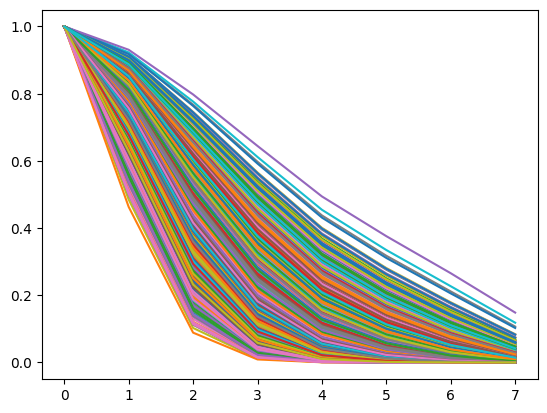

In [11]:
cph_sv2 = np.hstack([np.repeat(1,cph_sv.shape[0]).reshape(cph_sv.shape[0],1), cph_sv[:, :]])
for i in np.arange(0, cph_sv2.shape[0]):
    plt.plot(np.arange(0,8), cph_sv2[i,:])
# sv_true_t

Text(0, 0.5, 'True')

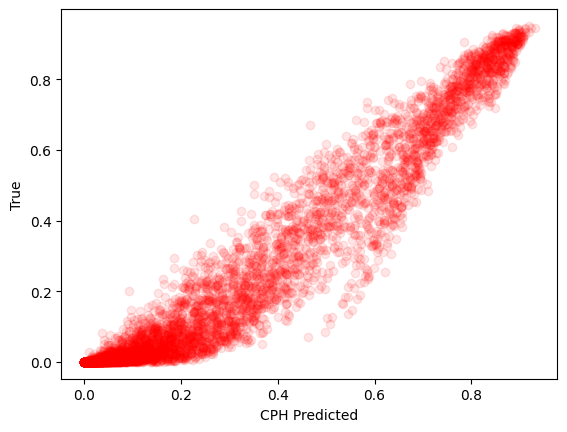

In [12]:
# plot True and Predicted
t_msk = np.arange(0,sv_mat.shape[1],TT_SCALE)
sv_true_t = sv_mat[:,t_msk]


for i in np.arange(0,sv_true_t.shape[0]):
    plt.plot(cph_sv[i,:6], sv_true_t[i,1:],"ro", alpha=0.1)

plt.xlabel("CPH Predicted")
plt.ylabel("True")

- Predicted values apear to be fairly biased upward throughout the body of the plots. IE True = 0.4 - Pred ~ 0.55

# Metrics
- C-INDEX
- TD-AUC
- Brier Score

In [19]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

In [20]:
# set up hazards to use
shp1,shp2,shp3 = pp.posterior_predictive["mu"].values.shape
shp4 = x_sk.shape[0]
shp5 = np.unique(b_tr_t).shape[0]

hz1 = pp.posterior_predictive["mu"].values.reshape(shp1*shp2, shp3).mean(axis=0).reshape(shp4,shp5)
chz1 = np.cumsum(hz1, axis=1)

cph_chz = cph.predict_cumulative_hazard_function(x_sk)
cph_chz = np.array([fn(fn.x) for fn in cph_chz])


In [23]:
# c-index at distinct times
for i in np.arange(chz1.shape[1]):
    ci = concordance_index_censored(y_sk["Status"], y_sk["Survival_in_days"], hz1[:,i])
    print(f"bart cindex {i}: {ci}")

for i in np.arange(cph_chz.shape[1]):
    ci = concordance_index_censored(y_sk["Status"], y_sk["Survival_in_days"], cph_chz[:,i])
    print(f"cph cindex {i}: {ci}")


bart cindex 0: (0.7791767951274138, 285280, 80850, 0, 0)
bart cindex 1: (0.7768224401168984, 284418, 81712, 0, 0)
bart cindex 2: (0.7773086062327589, 284596, 81534, 0, 0)
bart cindex 3: (0.776535656733947, 284313, 81817, 0, 0)
bart cindex 4: (0.7769999726872968, 284483, 81647, 0, 0)
bart cindex 5: (0.7771856990686368, 284551, 81579, 0, 0)
bart cindex 6: (0.7772321306639718, 284568, 81562, 0, 0)
cph cindex 0: (0.7328954196596837, 268335, 97795, 0, 0)
cph cindex 1: (0.7328954196596837, 268335, 97795, 0, 0)
cph cindex 2: (0.7328954196596837, 268335, 97795, 0, 0)
cph cindex 3: (0.7328954196596837, 268335, 97795, 0, 0)
cph cindex 4: (0.7328954196596837, 268335, 97795, 0, 0)
cph cindex 5: (0.7328954196596837, 268335, 97795, 0, 0)
cph cindex 6: (0.7328954196596837, 268335, 97795, 0, 0)


# time-auc

In [24]:
# CDA
cph_cda = cumulative_dynamic_auc(
    survival_train=y_sk, 
    survival_test=y_sk, 
    estimate=cph_chz[:,1:6], 
    times=bart_sv_t[1:6]
)

brt_cda = cumulative_dynamic_auc(
    survival_train=y_sk, 
    survival_test=y_sk, 
    estimate=hz1[:,1:6], 
    times=bart_sv_t[1:6]
)

print(f"BART: {brt_cda}")
print(f"CPH: {cph_cda}")

BART: (array([0.77500491, 0.83388571, 0.85763228, 0.90155606, 0.92233687]), 0.8317313334847004)
CPH: (array([0.74556484, 0.78614066, 0.789462  , 0.82837561, 0.83342629]), 0.7811016887638832)


# Integrated Brier score

In [25]:
bart_sv_brier = ssf.get_sv_fx(pp, x_sk)

In [26]:
cph_sv2 = np.hstack([np.repeat(1,cph_sv.shape[0]).reshape(cph_sv.shape[0],1), cph_sv[:, :]])
bart_ibs = integrated_brier_score(y_sk, y_sk, bart_sv_val[:, 1:-1], bart_sv_t[1:-1])
cph_ibs = integrated_brier_score(y_sk, y_sk, cph_sv2[:, 1:-1], bart_sv_t[1:-1])

print(f"bart brier: {bart_ibs}")
print(f"cph brier: {cph_ibs}")

bart brier: 0.08027213179045556
cph brier: 0.09589108953033819


- Across the 3 metrics BART performs slightly better than CPH. Though not necessarily outstandingly different, since the model keeps a proprotional hazard we wouldn't expect CPH to have to poor of a performance
- RMSE and BIAS may be a better evaluation of prediction accuracy given that we have the true sv curve. 

In [59]:
def get_metrics(f_t, f, times, quants = np.array([0.1, 0.25, 0.5, 0.75, 0.9])):
    f_t = np.matrix(f_t)[:,times]
    f = np.matrix(f)[:, times]

    rmse = np.round(np.sqrt(np.mean(np.power(f_t - f, 2), axis=0)), 4)
    bias = np.round(np.mean(f_t - f, axis = 0), 4)
    
    return rmse, bias


In [74]:
bart_met =  get_metrics(sv_true_t, bart_sv_val, times = [1,2,3,4,5])
cph_met = get_metrics(sv_true_t, cph_sv_val, times = [1,2,3,4,5])


print(f"BART RMSE: {bart_met[0]}")
print(f"CPH RMSE: {cph_met[0]}")
print(f"BART BIAS: {bart_met[1]}")
print(f"CPH BIAS: {cph_met[1]}")


BART RMSE: [[0.0567 0.0728 0.0592 0.0409 0.0226]]
CPH RMSE: [[0.1092 0.1431 0.117  0.0834 0.06  ]]
BART BIAS: [[-0.0021  0.0037  0.0096  0.0095  0.0042]]
CPH BIAS: [[-0.0498 -0.106  -0.0928 -0.062  -0.0416]]


- Based on RMSE and BIAS it can be seen that the BART performs significantly better than CPH. 
- RMSE for BART is ~1/2 of the CPH across the body of the curve
- BIAS is nearly unseen in BART but is consistently decreased in CPH ~(-0.05)-(-0.1)

# BART VAR EVAL
- Use PDP to evaluate variables
- Compare to the True difference expected from the model

In [ ]:
pp

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

/home/twj8/.local/lib/python3.10/site-packages/pymc_bart/utils.py:778: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  chains_hdi = az.hdi((var_imp_chains.T / var_imp_chains.sum(axis=1)).T)[indices]


(array([ 3,  0,  2,  4,  1,  7,  8, 10,  6,  5,  9]),
 array([<AxesSubplot:xlabel='covariables', ylabel='importance'>,
        <AxesSubplot:xlabel='number of covariables', ylabel='R²'>],
       dtype=object))

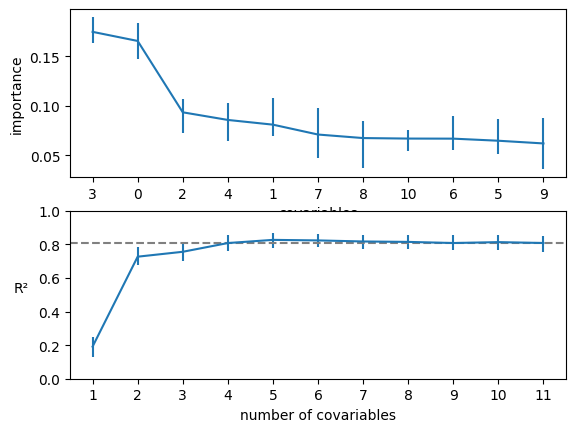

In [76]:
pmb.plot_variable_importance(
    idata=bdata,
    bartrv=f,
    X=b_tr_x,
    samples=300
)

- The function components are seen below. We would expect var3 (x_mat[:,2]) to have the greatest effect on the outcome.
- The Var importance plot shown above interestingly shows VAR 3 having the greatest importance, and greatest contribution to the outcome. Then time (var 0) is the second most import.
- FUNCTION:
    - 0.001 * np.exp(3+
    - 0.5*np.sin(np.pi*x_mat[:,0]*x_mat[:,1]) + 
    - np.power(x_mat[:,2],2) + 
    - 0.5*x_mat[:,3] +  
    - 0.25*x_mat[:,4])




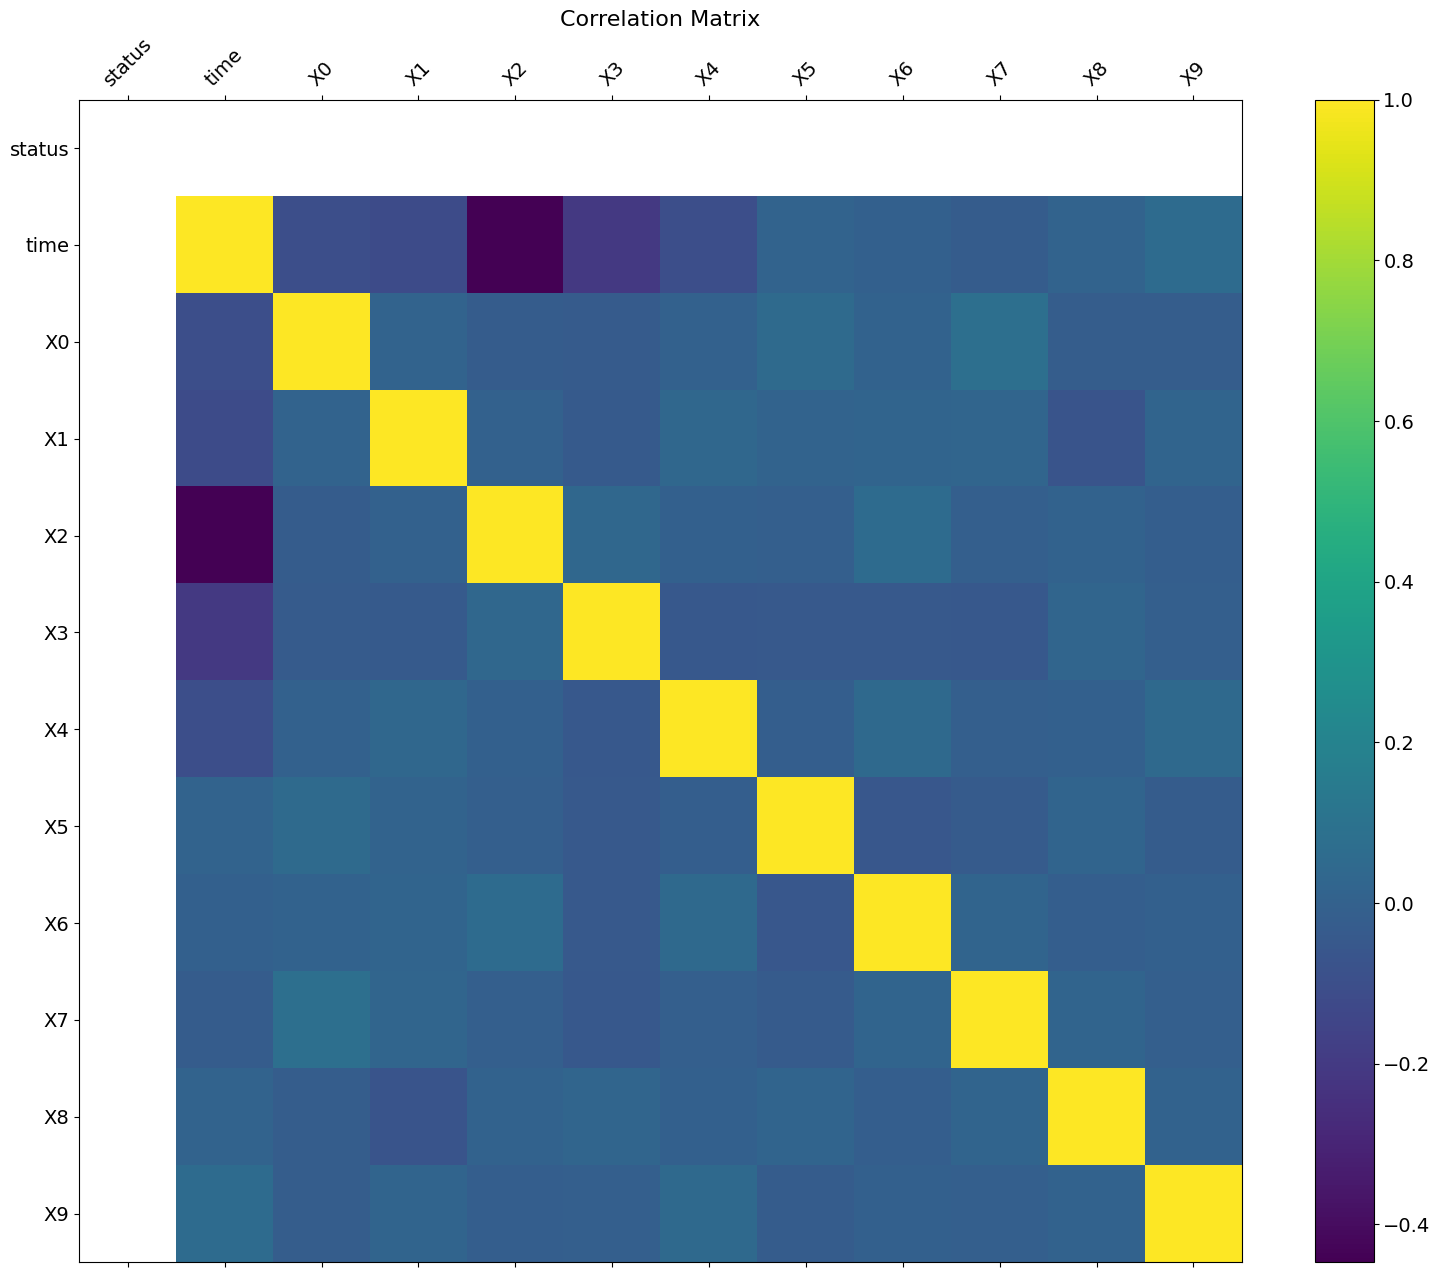

In [77]:
# Feature correlation plots
fm = plt.figure(figsize=(19, 15))
plt.matshow(train.corr(), fignum=fm.number)
plt.xticks(range(train.select_dtypes(['number']).shape[1]), train.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(train.select_dtypes(['number']).shape[1]), train.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

The correlation plot demonstrates the strong effect of var 3 on time of event.

- Below is a PDP function to compute a pdp for a give variable (in the context of sv). This function sets up the data and a call to the BART model to return posterior predictive in following step.
- Since these are all continuous variables, it is required to specify the values to compute PDP on for the given var.


Functions

In [405]:
# fdps for each var taking high and low value
SAMPLE=False
RN = 100
def get_pdp(dtst, VAR, TIMES, VAL=[0.25,0.5,0.75,], SAMPLE=False, RN=100):
    # get a mask for subset of obs
    p_idx = np.where(dtst[:,0] == TIMES)
    pdp = dtst[p_idx[0],:]
    # sample 
    if SAMPLE:
        tmp = dtst[np.where(dtst[:,0]==1)[0],:]
        # print(tmp.shape)
        rn_idx = np.random.choice(np.arange(0,tmp.shape[0]), RN, replace=False)
        pdp = tmp[rn_idx,:]
        # pdp = np.vstack([pdp]*len(TIMES))
        pdp = np.repeat(pdp, len(TIMES), axis=0)
        # print(pdp)
        pdp[:,0] = np.asarray(np.tile(TIMES, RN)).reshape(RN*len(TIMES),1)
        
    # make the pdp dataset
    rep = len(VAL)
    pdp_stack = np.vstack([pdp]*rep)
    val = np.quantile(np.asarray(pdp[:,VAR]), VAL)
    pdp_stack[:,VAR] = np.repeat(val, pdp.shape[0]).reshape(pdp_stack.shape[0],1)
    
    if SAMPLE:
        # pdp_stack is the pdp dataset and pdp is just to return the size of a single iteration of the pdp for sv_fx generation
        return pdp_stack, int(pdp_stack.shape[0]/len(TIMES)), len(TIMES)
    return pdp_stack, int(pdp_stack.shape[0]/len(TIMES)), len(TIMES)

def get_sv_fx(pp, r0, r1):
    p0 = pp.posterior_predictive["mu"].values.shape[0]
    p1 = pp.posterior_predictive["mu"].values.shape[1]
    p2 = pp.posterior_predictive["mu"].values.shape[2]
    pp_post = pp.posterior_predictive["mu"].values.reshape(p0*p1, p2).mean(axis=0).reshape(r0, r1)
    sv = (1-pp_post).cumprod(axis=1)
    return sv

def svplot(sv, tpt, brkpnt, qnt=[0.0275, 0.975], val=None):
    # Plots the SV points for each and Variance
    # Baseline is always the first Value
    istrt = 0
    shift = -.05
    for idx, iend in enumerate(brkpnt):
        qtmp = np.quantile(sv[istrt:iend,], [qnt[0],qnt[1]], 0)
        ptmp = sv[istrt:iend,].mean(0)
        qtmp = np.abs(qtmp - ptmp)
        tpt2 = [xi+shift for xi in tpt]
        plt.errorbar(x=tpt2, y=ptmp, yerr = qtmp, fmt="o", alpha=0.3, label=f"Val:{val[idx]}", capsize=10)
        istrt = iend
        shift += 0.05
    plt.legend()


- Gets the pdp from a sample of the dataset

In [213]:
VAR=3
TIMES = [1,2,3,4]
RN = 400
VAL = [0.25, 0.5, 0.75]
SAMPLE = True
pdp_l, r0, r1 = get_pdp(b_te_x, VAR=VAR, TIMES=TIMES, VAL=VAL, SAMPLE=SAMPLE, RN=RN)
vals = np.unique(pdp_l[:,VAR],axis=0)
with bart:
    pm.set_data({"x":pd.DataFrame(pdp_l)}, coords= {"obs":np.arange(0,pdp_l.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# get the sv fx
bart_sv_fx = get_sv_fx(pp2, r0, r1)

# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)

Sampling: [f, y_pred]


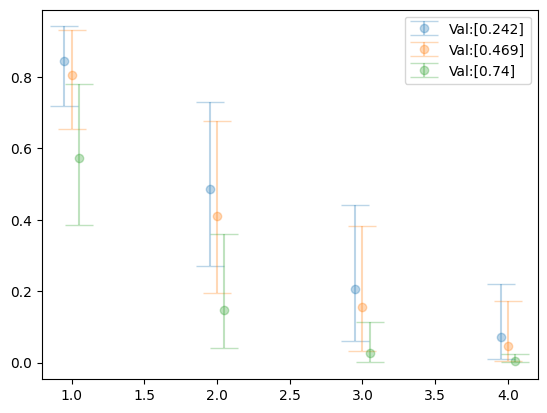

In [220]:
# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)

- From the sample PDP we can see that VAR 3 has a non-linear relationship with SV, where a linear increase in VAR 3 creates a non-linear difference in SV

Sampling: [f, y_pred]


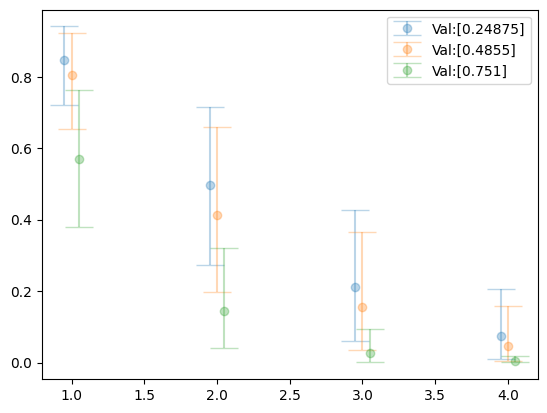

In [227]:
VAR=3
TIMES = [1,2,3,4]
RN = 1000
VAL = [0.25, 0.5, 0.75]
SAMPLE = False
pdp_l, r0, r1 = get_pdp(b_te_x, VAR=VAR, TIMES=TIMES, VAL=VAL, SAMPLE=SAMPLE, RN=RN)
vals = np.unique(pdp_l[:,VAR],axis=0)
with bart:
    pm.set_data({"x":pd.DataFrame(pdp_l)}, coords= {"obs":np.arange(0,pdp_l.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# get the sv fx
bart_sv_fx = get_sv_fx(pp2, r0, r1)

# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)

- Difference between PDP values
    - First version displays the difference at the level of draws. I don't expect we need this level of detail.
    - Second version is taken by getting the mean per obs and subtracting from the CF and then averaging over patients

In [304]:
def get_pdp_diff(pp, BRKPNT, r0, r1):
    p0 = pp.posterior_predictive["mu"].values.shape[0]
    p1 = pp.posterior_predictive["mu"].values.shape[1]
    p2 = pp.posterior_predictive["mu"].values.shape[2]
    zz = pp2.posterior_predictive["mu"].values.reshape(p0*p1, p2)
    out = []
    idx_refst = 0
    idx_refend = BRKPNT[0]
    for idx, brk in enumerate(BRKPNT[:-1]):
        out_tmp = []
        brk_end = BRKPNT[idx+1]
        print(brk,brk_end)
        for i in np.arange(0,zz.shape[0]):
            # get draw
            tmp = zz[i,:].reshape(r0,r1)
            # print(tmp)
            # print(tmp.shape)
            
            # print(tmp)
            prd = (1-tmp).cumprod(1)
            # print(prd)
            # break
            # get difference
            # print(idxst, brk, BRKPNT[idx+1])
            # print(prd.shape)
            q1 = prd[brk:brk_end]- prd[idx_refst:idx_refend]
            # print(q1)

            out_tmp.append(q1)
        out.append(out_tmp)
        print(len(out_tmp))
        if brk_end == BRKPNT[-1]:
            break
        # idxst = brk
    return out

In [305]:
pdpd = get_pdp_diff(pp2, BRKPNT, r0, r1)

1000 2000
1200
2000 3000
1200


In [308]:
def plt_pdp_diff(pdpd, ntimes):
    fig,ax = plt.subplots(ntimes)
    c=0
    col=["ro","bo"]
    for dff in pdpd:
        for draw in dff:
            x = np.arange(0,draw.shape[0])
            for t in np.arange(0, draw.shape[1]):
                ax[t].plot(x, draw[:,t], col[c], alpha=0.007)
        print(col[c])
        c+=1

ro
bo


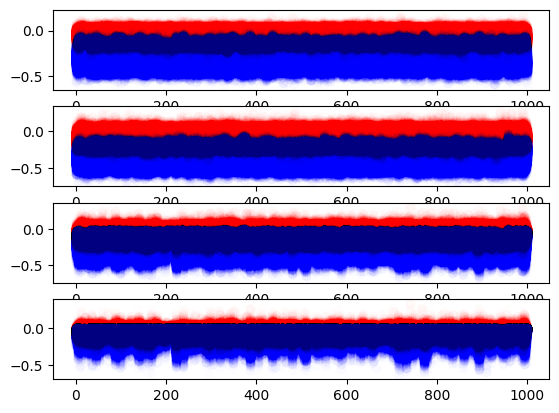

In [309]:
plt_pdp_diff(pdpd, 4)

In [370]:
def get_diff_avg(sv, BRKPNT):
    idx_refst = 0
    idx_refen = RN
    mean = []
    qt = []
    for idx,brk in enumerate(BRKPNT):
        diff = sv[brk:BRKPNT[idx+1]] - sv[idx_refst:idx_refen]
        d_mn = diff.mean(0)
        d_qt = np.quantile(diff, [0.0275, 0.975],0)
        # print(d_mn.shape)
        mean.append(d_mn)
        qt.append(d_qt)
        if BRKPNT[idx+1] == BRKPNT[-1]:
            break
    return mean, qt
# bart_sv_fx


In [324]:
diff_mn , diff_qt = get_diff_avg(bart_sv_fx, BRKPNT)

(4,)
(4,)


In [353]:
def plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=None, TITLE=None):
    # ax,fig = plt.figure(diff_mn[0].shape[1])
    # color = ["ro","bo"]
    for idx, set in enumerate(diff_mn):
        print(set.shape)
        x = np.arange(0,set.shape[0])
        err = np.abs(diff_qt[0] - diff_mn[0])
        plt.errorbar(TIMES, set, yerr=err, alpha=0.3, fmt="o", label=f"diff {LABEL[idx]}")
    plt.legend()
    plt.title(f"Diff from Ref: {TITLE}")

(4,)
(4,)


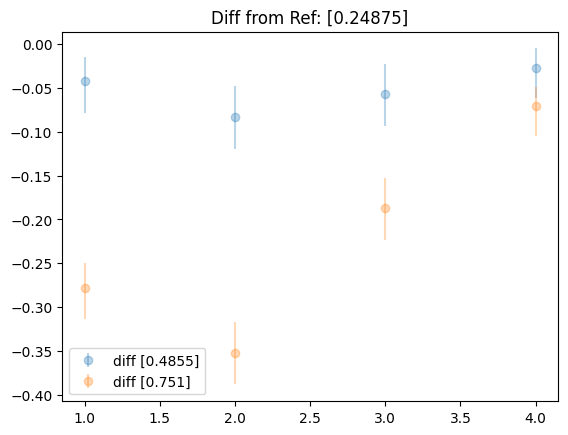

In [354]:
plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals[1:], TITLE=vals[0])

- Here we can see the measure of avg difference between the mean value across draws for each patient from the reference level and associated credible interval

Get the expected difference

In [358]:
ttt = [t * 10 for t in TIMES]
ttt

[10, 20, 30, 40]

In [364]:
s0 = pdp_l.shape[0]/len(vals)/len(TIMES)
# pdp_l.shape[0]
s0

1000.0

In [385]:
# get the true difference


def get_true_sv(lmbda, a, pdp_l, TIMES, scale=10):
    
    aaa = a
    ttt = [t * scale for t in TIMES]
    msk = np.arange(0,pdp_l.shape[0],len(TIMES))
    # xxx = np.asarray(pdp_l[msk,1:])
    x_mat = np.asarray(pdp_l[msk,1:])
    lll = eval(lmbda)
    s0 = int(pdp_l.shape[0]/len(TIMES))
    ooo = np.zeros((s0,len(TIMES)))
    for idx, val in enumerate(ttt):
        pdp_true = np.exp(-1* np.power((lll*val), aaa))
        ooo[:,idx] = pdp_true
    return ooo

# xxx.shape

In [387]:
LAMBDA2 = "0.001 * np.exp(3+0.5*np.sin(np.pi*xxx[:,0]*xxx[:,1]) + np.power(xxx[:,2],2) + 0.5*xxx[:,3] + 0.25*xxx[:,4])" 
ooo = get_true_sv(lmbda = LAMBDA, a=2, pdp_l = pdp_l, TIMES=TIMES)
ooo

array([[5.53696224e-01, 9.39909948e-02, 4.89152248e-03, 7.80449819e-05],
       [6.89547055e-01, 2.26076610e-01, 3.52431868e-02, 2.61229686e-03],
       [8.69808088e-01, 5.72392280e-01, 2.84977766e-01, 1.07343332e-01],
       ...,
       [6.88223967e-01, 2.24346434e-01, 3.46392225e-02, 2.53324204e-03],
       [6.18403871e-01, 1.46247617e-01, 1.32266481e-02, 4.57462181e-04],
       [6.27293079e-01, 1.54839579e-01, 1.50395368e-02, 5.74814788e-04]])

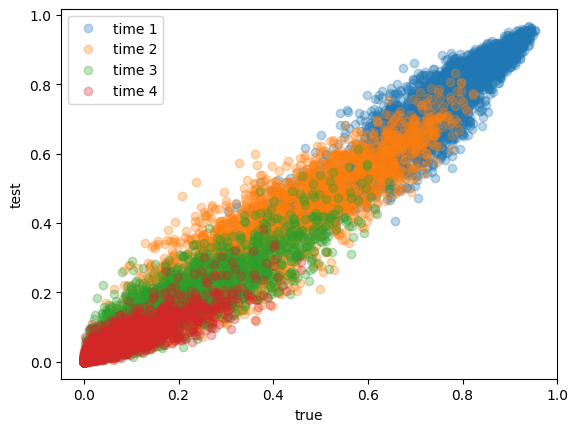

In [369]:
# check how the predictions compare

for i in np.arange(0,len(TIMES)):
    plt.plot(ooo[:,i], bart_sv_fx[:,i], "o", alpha=0.3, label = f"time {TIMES[i]}" )
plt.ylabel("test")
plt.xlabel("true")
plt.legend()


- Predictions and True expectations align fairly well over the 3 values. There might be somes small bias in the later time predictions.

(4,)
(4,)
(4,)
(4,)


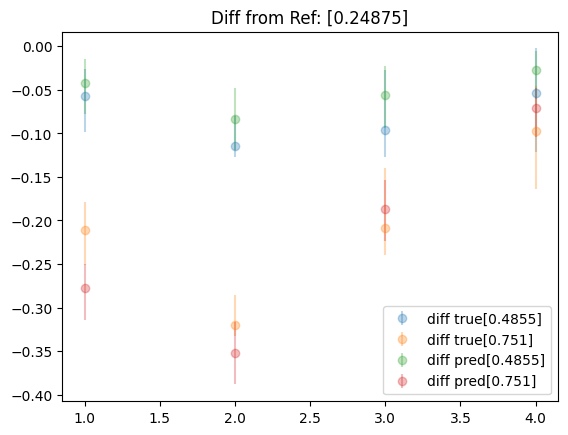

In [378]:
odiff_mn , odiff_qt = get_diff_avg(ooo, BRKPNT)
vals2 = ["true"+str(v) for v in vals]
vals3 = ["pred"+str(v) for v in vals]
plt_diff_avg(odiff_mn, odiff_qt, TIMES, LABEL=vals2[1:], TITLE=vals[0])
plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals3[1:], TITLE=vals[0])

- The difference between marginal effects by VAR 3 from the true and predicted are conserved very well, with the difference being only semi apparent in the earliest timepoint.


Quick check the other variables

VAR 1

Sampling: [f, y_pred]


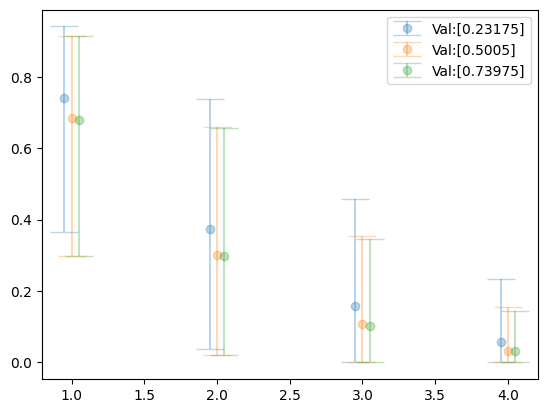

In [379]:
VAR=1
TIMES = [1,2,3,4]
RN = 400
VAL = [0.25, 0.5, 0.75]
SAMPLE = True
pdp_l, r0, r1 = get_pdp(b_te_x, VAR=VAR, TIMES=TIMES, VAL=VAL, SAMPLE=SAMPLE, RN=RN)
vals = np.unique(pdp_l[:,VAR],axis=0)
with bart:
    pm.set_data({"x":pd.DataFrame(pdp_l)}, coords= {"obs":np.arange(0,pdp_l.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# get the sv fx
bart_sv_fx = get_sv_fx(pp2, r0, r1)

# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)

- Var 1 displays a weak effect on dimineshing the SV. This effect appears to be non-linear and decreases with increase in VAR 1.
- Since we know this effect is interactive with VAR 2 from the true model and is scaled by a sin function, the decreasing effect as value increases in appropriate

Var 2

Sampling: [f, y_pred]


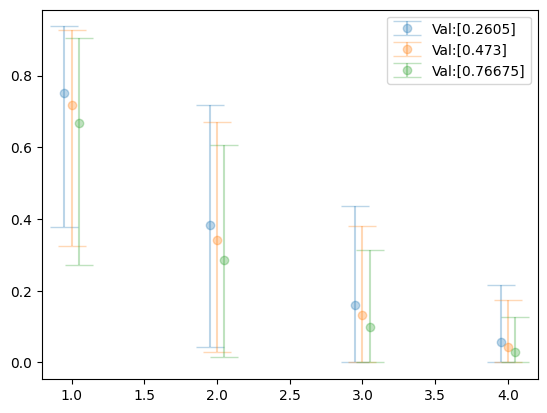

In [380]:
VAR=2
TIMES = [1,2,3,4]
RN = 400
VAL = [0.25, 0.5, 0.75]
SAMPLE = True
pdp_l, r0, r1 = get_pdp(b_te_x, VAR=VAR, TIMES=TIMES, VAL=VAL, SAMPLE=SAMPLE, RN=RN)
vals = np.unique(pdp_l[:,VAR],axis=0)
with bart:
    pm.set_data({"x":pd.DataFrame(pdp_l)}, coords= {"obs":np.arange(0,pdp_l.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# get the sv fx
bart_sv_fx = get_sv_fx(pp2, r0, r1)

# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)

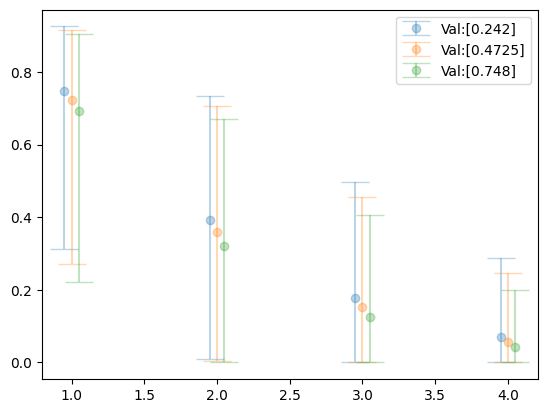

In [414]:
ooo = get_true_sv(lmbda = LAMBDA, a=2, pdp_l = pdp_l, TIMES=TIMES)
svplot(ooo, tpt=TIMES, brkpnt=BRKPNT, val=vals)

(4,)
(4,)
(4,)
(4,)


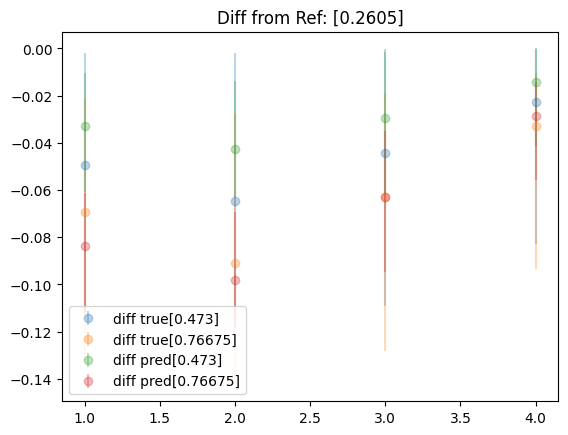

In [393]:
odiff_mn , odiff_qt = get_diff_avg(ooo, BRKPNT)
diff_mn , diff_qt = get_diff_avg(bart_sv_fx, BRKPNT)
vals2 = ["true"+str(v) for v in vals]
vals3 = ["pred"+str(v) for v in vals]
plt_diff_avg(odiff_mn, odiff_qt, TIMES, LABEL=vals2[1:], TITLE=vals[0])
plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals3[1:], TITLE=vals[0])

Var 4

Sampling: [f, y_pred]


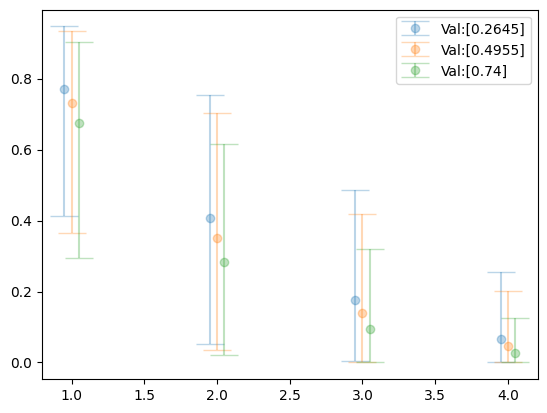

In [403]:
VAR=4
TIMES = [1,2,3,4]
RN = 400
VAL = [0.25, 0.5, 0.75]
SAMPLE = True
pdp_l, r0, r1 = get_pdp(b_te_x, VAR=VAR, TIMES=TIMES, VAL=VAL, SAMPLE=SAMPLE, RN=RN)
vals = np.unique(pdp_l[:,VAR],axis=0)
with bart:
    pm.set_data({"x":pd.DataFrame(pdp_l)}, coords= {"obs":np.arange(0,pdp_l.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# get the sv fx
bart_sv_fx = get_sv_fx(pp2, r0, r1)

# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)

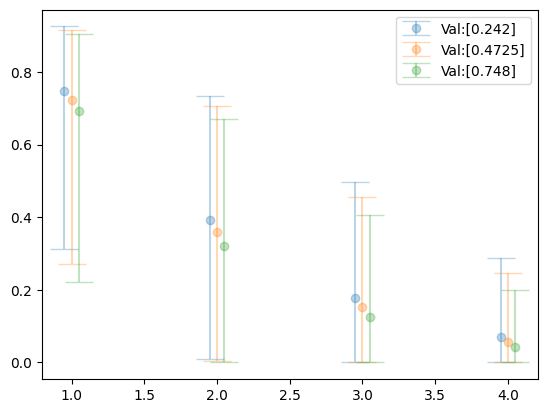

In [413]:
ooo = get_true_sv(lmbda = LAMBDA, a=2, pdp_l = pdp_l, TIMES=TIMES)
svplot(ooo, tpt=TIMES, brkpnt=BRKPNT, val=vals)

(4,)
(4,)
(4,)
(4,)


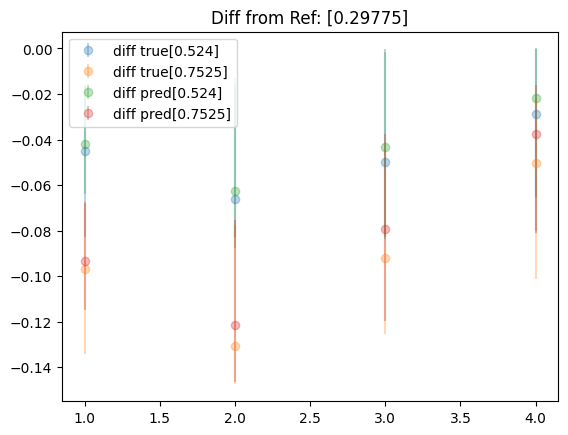

In [396]:
odiff_mn , odiff_qt = get_diff_avg(ooo, BRKPNT)
diff_mn , diff_qt = get_diff_avg(bart_sv_fx, BRKPNT)
vals2 = ["true"+str(v) for v in vals]
vals3 = ["pred"+str(v) for v in vals]
plt_diff_avg(odiff_mn, odiff_qt, TIMES, LABEL=vals2[1:], TITLE=vals[0])
plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals3[1:], TITLE=vals[0])

Val 5

Sampling: [f, y_pred]


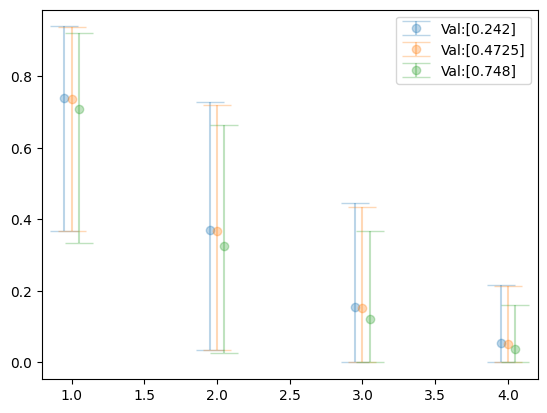

In [410]:
VAR=5
TIMES = [1,2,3,4]
RN = 400
VAL = [0.25, 0.5, 0.75]
SAMPLE = True
pdp_l, r0, r1 = get_pdp(b_te_x, VAR=VAR, TIMES=TIMES, VAL=VAL, SAMPLE=SAMPLE, RN=RN)
vals = np.unique(pdp_l[:,VAR],axis=0)
with bart:
    pm.set_data({"x":pd.DataFrame(pdp_l)}, coords= {"obs":np.arange(0,pdp_l.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# get the sv fx
bart_sv_fx = get_sv_fx(pp2, r0, r1)

# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)

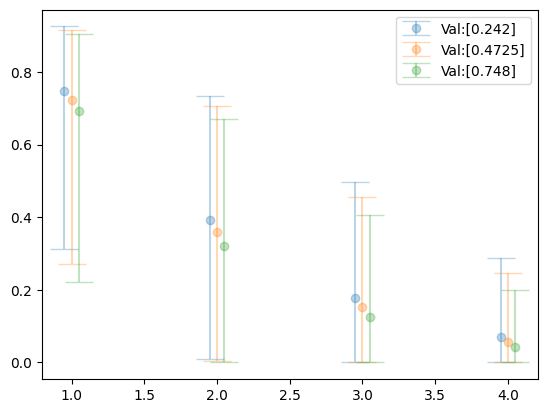

In [411]:
ooo = get_true_sv(lmbda = LAMBDA, a=2, pdp_l = pdp_l, TIMES=TIMES)
svplot(ooo, tpt=TIMES, brkpnt=BRKPNT, val=vals)

(4,)
(4,)
(4,)
(4,)


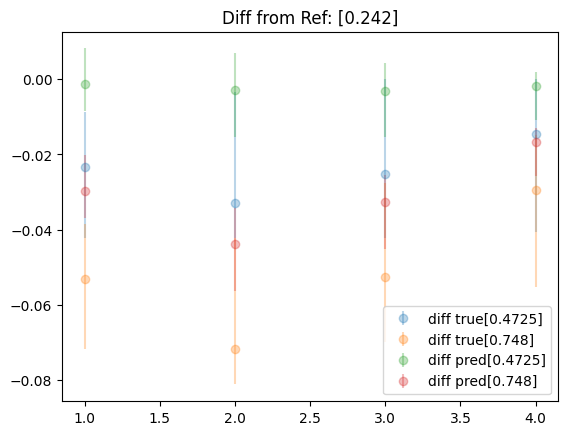

In [412]:
odiff_mn , odiff_qt = get_diff_avg(ooo, BRKPNT)
diff_mn , diff_qt = get_diff_avg(bart_sv_fx, BRKPNT)
vals2 = ["true"+str(v) for v in vals]
vals3 = ["pred"+str(v) for v in vals]
plt_diff_avg(odiff_mn, odiff_qt, TIMES, LABEL=vals2[1:], TITLE=vals[0])
plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals3[1:], TITLE=vals[0])

Var 6

Sampling: [f, y_pred]


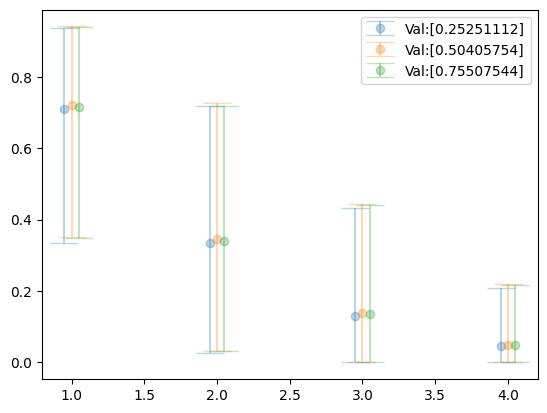

In [416]:
VAR=6
TIMES = [1,2,3,4]
RN = 400
VAL = [0.25, 0.5, 0.75]
SAMPLE = True
pdp_l, r0, r1 = get_pdp(b_te_x, VAR=VAR, TIMES=TIMES, VAL=VAL, SAMPLE=SAMPLE, RN=RN)
vals = np.unique(pdp_l[:,VAR],axis=0)
with bart:
    pm.set_data({"x":pd.DataFrame(pdp_l)}, coords= {"obs":np.arange(0,pdp_l.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# get the sv fx
bart_sv_fx = get_sv_fx(pp2, r0, r1)

# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)

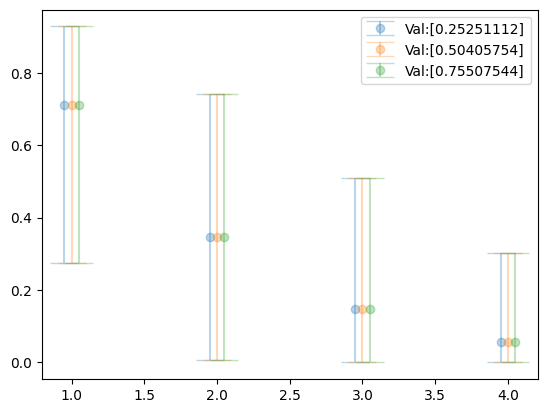

In [417]:
ooo = get_true_sv(lmbda = LAMBDA, a=2, pdp_l = pdp_l, TIMES=TIMES)
svplot(ooo, tpt=TIMES, brkpnt=BRKPNT, val=vals)

(4,)
(4,)
(4,)
(4,)


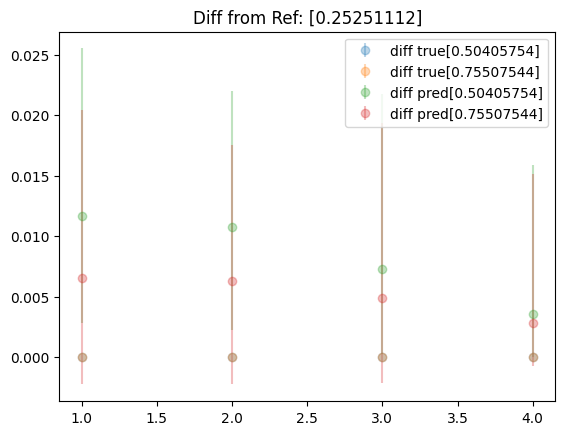

In [418]:
odiff_mn , odiff_qt = get_diff_avg(ooo, BRKPNT)
diff_mn , diff_qt = get_diff_avg(bart_sv_fx, BRKPNT)
vals2 = ["true"+str(v) for v in vals]
vals3 = ["pred"+str(v) for v in vals]
plt_diff_avg(odiff_mn, odiff_qt, TIMES, LABEL=vals2[1:], TITLE=vals[0])
plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals3[1:], TITLE=vals[0])

Var 6 in not incorporated into the DGP and its difference should be 0. The observed difference is less at most ~0.01, indicaating that the model did a fairly good job in not producing a high difference value on this valiable.